Extracting ../../MNIST/train-images-idx3-ubyte.gz
Extracting ../../MNIST/train-labels-idx1-ubyte.gz
Extracting ../../MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST/t10k-labels-idx1-ubyte.gz
before:  (55000, 784)
before:  (10000, 784)
after:  (55000, 784)
after:  (10000, 784)
Train on 55000 samples, validate on 10000 samples
Epoch 1/50
55000/55000 [==============================] - 4s - loss: 2.5442 - mean_absolute_error: 0.4413 - acc: 0.0043 - val_loss: 2.4313 - val_mean_absolute_error: 0.3615 - val_acc: 0.0040
Epoch 2/50
55000/55000 [==============================] - 4s - loss: 2.3619 - mean_absolute_error: 0.3197 - acc: 0.0048 - val_loss: 2.3768 - val_mean_absolute_error: 0.2959 - val_acc: 0.0083
Epoch 3/50
55000/55000 [==============================] - 4s - loss: 2.3464 - mean_absolute_error: 0.2845 - acc: 0.0144 - val_loss: 2.3730 - val_mean_absolute_error: 0.2758 - val_acc: 0.0161
Epoch 4/50
55000/55000 [==============================] - 4s - loss: 2.3426 - mean_absolute_e

55000/55000 [==============================] - 4s - loss: 2.0773 - mean_absolute_error: 0.1125 - acc: 0.0105 - val_loss: 2.1048 - val_mean_absolute_error: 0.1141 - val_acc: 0.0095
Epoch 42/50
55000/55000 [==============================] - 4s - loss: 2.0754 - mean_absolute_error: 0.1135 - acc: 0.0109 - val_loss: 2.1029 - val_mean_absolute_error: 0.1150 - val_acc: 0.0096
Epoch 43/50
55000/55000 [==============================] - 4s - loss: 2.0735 - mean_absolute_error: 0.1143 - acc: 0.0107 - val_loss: 2.1011 - val_mean_absolute_error: 0.1160 - val_acc: 0.0099
Epoch 44/50
55000/55000 [==============================] - 4s - loss: 2.0718 - mean_absolute_error: 0.1151 - acc: 0.0107 - val_loss: 2.0994 - val_mean_absolute_error: 0.1167 - val_acc: 0.0098
Epoch 45/50
55000/55000 [==============================] - 4s - loss: 2.0701 - mean_absolute_error: 0.1158 - acc: 0.0104 - val_loss: 2.0979 - val_mean_absolute_error: 0.1172 - val_acc: 0.0102
Epoch 46/50
55000/55000 [===========================

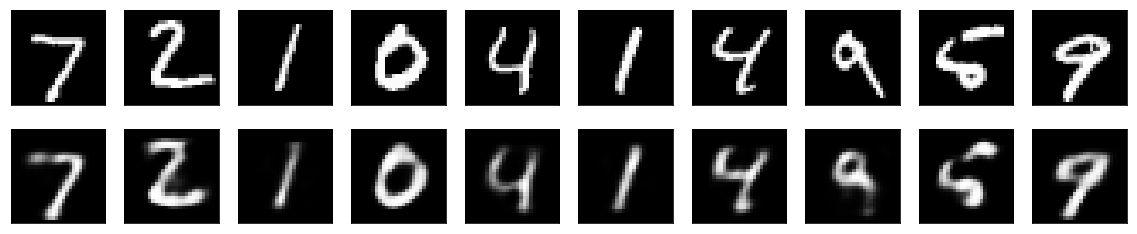

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import metrics
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

############ AutoEncoder Model ##########################
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction

autoencoder = Model(input_img, decoded)

################ Separate Encoder Model for Reconstruction Evaluation ##############
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

################# Separate Decoder Model #############
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

###### Compile and Training
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #效果太差无法区分字符
#换rmsprop优化器结果好一些， 损失函数用多分类的比二分类的好
autoencoder.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
                    metrics=[metrics.mae, 'accuracy'])

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../MNIST') #don't use one hot encoding
x_train, x_test = mnist.train.images, mnist.test.images

## normalize all values between 0 and 1, flatten the 28*28 image to 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("before: ", x_train.shape)
print("before: ", x_test.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) #flatten
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print("after: ", x_train.shape)
print("after: ", x_test.shape)

#after 50 epoch, loss value ~ 0.11 stably
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))#,                callbacks=[TensorBoard(log_dir='./tmp/autoencoder')])


############ Visualize the reconstructed inputs
# encode and decode some digits, note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# simple loss: 2.0596 - val_loss: 2.0872